## Finding LTE Worst Performing Cells/Sectors using Anomaly Detection

In [1]:
import numpy as np
import pandas as pd
from numpy import pi, sin, cos
import plotly.graph_objs as go
import plotly.express as px
import math
import matplotlib.pyplot as plt
from sklearn import model_selection
import seaborn as sns
from sklearn import ensemble
from sklearn import svm
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import IsolationForest

### Reading a selection of LTE busy hour sector level KPI's
- KPI's of all LTE cells (including all carriers on the same and different bands) of a sector are aggregated to make the sector level KPI's

In [2]:
KPI_df = pd.read_csv("LTE_BH_Sector_KPI.csv", parse_dates=["Datetime"])
KPI_df.head(3)

,Datetime,SECTOR,Province,Vendor,Total_Payload_GB,Total_DL_Payload(GB),UserThroughput,DL_Spectral_efficiency,Average_Reported_CQI,DL_PRB_UTILIZATION,Sector_Bandwidth(MHz),cell_availability_include_manual_blocking,ConnectedUser
0,2022-12-13 17:00:00,QM0145C,QM,Huawei,0.159,0.142,87.215,1.221,13.183,1.441,20.0,100.0,3.975
1,2022-12-13 21:00:00,QN0088C,QN,Huawei,12.126,10.923,13.131,1.284,10.122,35.002,60.0,100.0,114.181
2,2022-12-13 21:00:00,QN0154A,QN,Huawei,7.300,6.702,28.580,2.508,11.050,32.986,20.0,100.0,51.811


In [3]:
KPI_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383755 entries, 0 to 383754
Data columns (total 13 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   Datetime                                   383755 non-null  datetime64[ns]
 1   SECTOR                                     383755 non-null  object        
 2   Province                                   383755 non-null  object        
 3   Vendor                                     383755 non-null  object        
 4   Total_Payload_GB                           383683 non-null  float64       
 5   Total_DL_Payload(GB)                       383683 non-null  float64       
 6   UserThroughput                             383340 non-null  float64       
 7   DL_Spectral_efficiency                     383586 non-null  float64       
 8   Average_Reported_CQI                       383619 non-null  float64       
 9   DL_P

In [4]:
# LTE Network Dimensions
df = KPI_df.drop_duplicates(subset=['SECTOR'])
df_summary = df[['Vendor','SECTOR']].groupby(by=['Vendor']).count()
df_summary.loc['Grand Total'] = df_summary.sum()
df_summary

,SECTOR
Vendor,
Ericsson,14033
Huawei,26082
Nokia,16370
Grand Total,56485


### Data Cleaning

##### Droping rows with null

In [5]:
KPI_df.dropna(inplace=True)

In [6]:
KPI_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383174 entries, 0 to 383754
Data columns (total 13 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   Datetime                                   383174 non-null  datetime64[ns]
 1   SECTOR                                     383174 non-null  object        
 2   Province                                   383174 non-null  object        
 3   Vendor                                     383174 non-null  object        
 4   Total_Payload_GB                           383174 non-null  float64       
 5   Total_DL_Payload(GB)                       383174 non-null  float64       
 6   UserThroughput                             383174 non-null  float64       
 7   DL_Spectral_efficiency                     383174 non-null  float64       
 8   Average_Reported_CQI                       383174 non-null  float64       
 9   DL_P

##### Dropping sectors with unreliable data

In [7]:
drop_index = KPI_df[(KPI_df['cell_availability_include_manual_blocking'] < 99) | 
                      (KPI_df['Total_DL_Payload(GB)'] == 0) | 
                      ((KPI_df['SECTOR'].str.len()) <= 6) | 
                      (KPI_df['Sector_Bandwidth(MHz)'] == 0) |
                      (KPI_df['UserThroughput'] == 0) 
                     ].index
KPI_df.drop(drop_index , inplace=True)

In [8]:
KPI_df.shape

(377038, 13)

### Feature Engineering

In [9]:
# PPM (Payload Per MHz)
KPI_df['PPM'] = KPI_df['Total_DL_Payload(GB)'] / KPI_df['Sector_Bandwidth(MHz)']

In [10]:
# UPM (User Per MHz)
KPI_df['UPM'] = KPI_df['ConnectedUser'] / KPI_df['Sector_Bandwidth(MHz)']

In [11]:
# Creating name of the day
KPI_df['Day'] = KPI_df['Datetime'].dt.day_name()
# creating hour
KPI_df['Hour'] = KPI_df['Datetime'].dt.hour

In [12]:
# Droping weekend days
drop_index = KPI_df[(KPI_df['Day'] == "Thursday") | 
                      (KPI_df['Day'] == "Friday") 
                     ].index
KPI_df.drop(drop_index , inplace=True)

In [13]:
KPI_df.shape

(268604, 17)

### EDA

In [14]:
coverage_df = pd.read_excel("Coverage_Type.xlsx")

In [15]:
coverage_df.head()

,Sector_ID,Latitude,Longitude,Azimuth,TA,Target,Popu_Type
0,AG0001A,37.531260,45.031880,85,0.566389,1,Semi-Residential
1,AG0001B,37.531260,45.031880,190,0.654871,1,Semi-Commercial
2,AG0001C,37.531260,45.031880,300,0.703661,1,Semi-Residential
3,AG0002C,37.554125,45.085994,334,0.440847,1,Semi-Residential
4,AG0002B,37.554125,45.085994,240,0.485209,1,Semi-Commercial


In [16]:
cells_df = KPI_df.drop_duplicates(subset=['SECTOR'])

In [17]:
cells_df.shape

(56342, 17)

In [18]:
cells_df = pd.merge(coverage_df, cells_df, how='left', left_on='Sector_ID', right_on='SECTOR')

In [19]:
cells_df.shape

(76865, 24)

In [20]:
cells_df.dropna(inplace=True)
cells_df.drop(columns='SECTOR', index=1, inplace=True)
cells_df.reset_index(inplace=True, drop=True)
cells_df.shape

(54224, 23)

In [21]:
Labels = {0 : "Umbrella",
          1 : "City Capacity",
          2 : "Rural",
          3 : "City Coverage"}

cells_df["Label"] = cells_df["Target"].map(Labels)

In [22]:
cells_df.head(3)

,Sector_ID,Latitude,Longitude,Azimuth,TA,Target,Popu_Type,Datetime,Province,Vendor,...,Average_Reported_CQI,DL_PRB_UTILIZATION,Sector_Bandwidth(MHz),cell_availability_include_manual_blocking,ConnectedUser,PPM,UPM,Day,Hour,Label
0,AG0001A,37.531260,45.031880,85,0.566389,1,Semi-Residential,2022-12-14 22:00:00,AG,Huawei,...,10.247,26.177,60.0,100.0,88.709,0.174850,1.478483,Wednesday,22.0,City Capacity
1,AG0001C,37.531260,45.031880,300,0.703661,1,Semi-Residential,2022-12-11 14:00:00,AG,Huawei,...,9.959,41.876,60.0,100.0,198.271,0.291833,3.304517,Sunday,14.0,City Capacity
2,AG0002C,37.554125,45.085994,334,0.440847,1,Semi-Residential,2022-12-14 14:00:00,AG,Huawei,...,9.940,24.401,70.0,100.0,125.551,0.135843,1.793586,Wednesday,14.0,City Capacity


In [23]:
cells_df[['Popu_Type', 'DL_Spectral_efficiency', 'PPM', 'UPM', 'Sector_Bandwidth(MHz)']].groupby(by=['Popu_Type']).mean().round(2)

,DL_Spectral_efficiency,PPM,UPM,Sector_Bandwidth(MHz)
Popu_Type,,,,
Commercial,1.71,0.17,2.68,49.28
Residential,1.85,0.27,2.48,56.15
Semi-Commercial,1.80,0.18,2.10,48.88
Semi-Residential,1.88,0.27,2.41,51.22


In [24]:
cells_df[['Label', 'DL_Spectral_efficiency', 'PPM', 'UPM', 'Sector_Bandwidth(MHz)']].groupby(by=['Label']).mean().round(2)

,DL_Spectral_efficiency,PPM,UPM,Sector_Bandwidth(MHz)
Label,,,,
City Capacity,1.57,0.24,2.63,69.32
City Coverage,1.77,0.25,2.50,53.68
Rural,2.27,0.22,2.06,30.02
Umbrella,1.92,0.13,1.30,22.94


#### Creating the feature list

In [25]:
# making a feature list
features = [
    f for f in cells_df.columns if f not in ('index', 'Sector_ID', 'Latitude', 'Longitude', 'Azimuth', 'TA',
                                       'Target', 'Datetime', 'Province', 'Vendor', 'Total_Payload_GB',
                                       'Total_DL_Payload(GB)', 'UserThroughput',
                                       'Average_Reported_CQI', 'DL_PRB_UTILIZATION',
                                       'cell_availability_include_manual_blocking', 'ConnectedUser',
                                       'Day', 'Label', 'Popu_Type')
]

features

['DL_Spectral_efficiency', 'Sector_Bandwidth(MHz)', 'PPM', 'UPM', 'Hour']

### Using Isolation Forest Algorithm for Anomaly Detection
##### The Isolation Forest is an ensemble of “Isolation Trees” that “isolate” observations by recursive random partitioning, which can be represented by a tree structure. The number of splittings required to isolate a sample is lower for outliers and higher for inliers.

In [26]:
# Count of samples per BW
df_summary = cells_df[['Sector_Bandwidth(MHz)', 'PPM']].groupby(by=['Sector_Bandwidth(MHz)']).count()
df_summary.loc['Grand Total'] = df_summary.sum()
df_summary

,PPM
Sector_Bandwidth(MHz),
5.0,24
10.0,157
15.0,117
20.0,14095
25.0,7
30.0,2672
35.0,837
40.0,6114
45.0,8


In [27]:
# Count of samples per hour
df_summary = cells_df[['Hour', 'PPM']].groupby(by=['Hour']).count()
df_summary.loc['Grand Total'] = df_summary.sum()
df_summary

,PPM
Hour,
0.0,871
1.0,28
2.0,9
3.0,4
4.0,3
5.0,2
6.0,22
7.0,46
8.0,134


In [28]:
cells_df.head(3)

,Sector_ID,Latitude,Longitude,Azimuth,TA,Target,Popu_Type,Datetime,Province,Vendor,...,Average_Reported_CQI,DL_PRB_UTILIZATION,Sector_Bandwidth(MHz),cell_availability_include_manual_blocking,ConnectedUser,PPM,UPM,Day,Hour,Label
0,AG0001A,37.531260,45.031880,85,0.566389,1,Semi-Residential,2022-12-14 22:00:00,AG,Huawei,...,10.247,26.177,60.0,100.0,88.709,0.174850,1.478483,Wednesday,22.0,City Capacity
1,AG0001C,37.531260,45.031880,300,0.703661,1,Semi-Residential,2022-12-11 14:00:00,AG,Huawei,...,9.959,41.876,60.0,100.0,198.271,0.291833,3.304517,Sunday,14.0,City Capacity
2,AG0002C,37.554125,45.085994,334,0.440847,1,Semi-Residential,2022-12-14 14:00:00,AG,Huawei,...,9.940,24.401,70.0,100.0,125.551,0.135843,1.793586,Wednesday,14.0,City Capacity


In [29]:
X = cells_df[(cells_df['Label'] == 'City Capacity') & (cells_df['Popu_Type'] == 'Residential') & (cells_df['Sector_Bandwidth(MHz)'] == 75 ) & (cells_df['Hour'] == 23 )][features]
y = X['DL_Spectral_efficiency']
X.drop(columns=['Sector_Bandwidth(MHz)', 'Hour', 'DL_Spectral_efficiency'], inplace=True)

In [30]:
X.shape

(958, 2)

In [31]:
X.head(1)

,PPM,UPM
30718,0.455733,4.95732


In [32]:
# Feature Scalling
from sklearn import preprocessing

Scalling = 'standard' # 'none', 'normal', 'standard'

if Scalling == 'standard':
    scalled_X = preprocessing.StandardScaler().fit_transform(X)
    
elif Scalling == 'normal':
    scalled_X = preprocessing.MinMaxScaler().fit_transform(X)
    
elif Scalling == 'none':
    scalled_X = X.to_numpy()

print(scalled_X.min())
print(scalled_X.max())

-2.307647749439513
4.058971598177613


In [33]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=1) # max_samples=100
clf.fit(scalled_X)

IsolationForest(random_state=1)

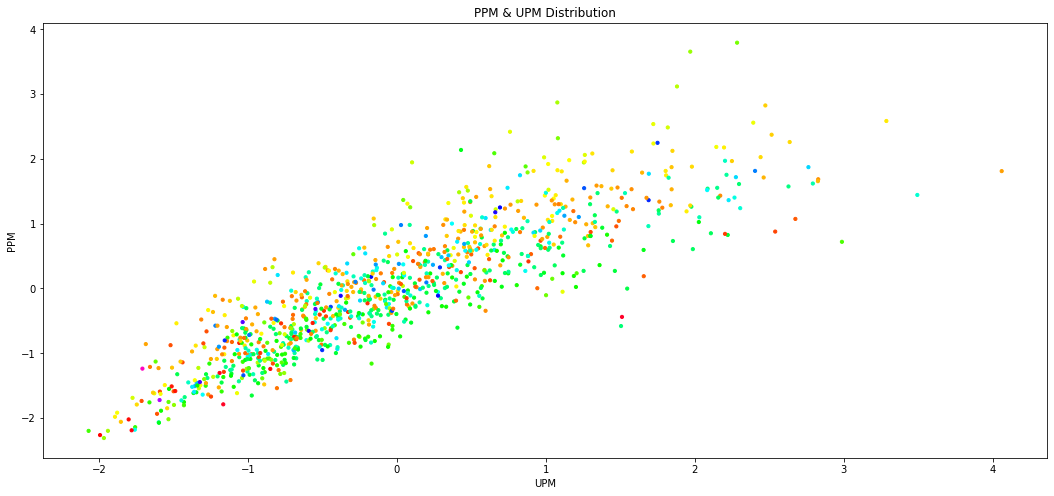

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,8)

scatter = plt.scatter(scalled_X[:, 1], scalled_X[:, 0], c=y,cmap='gist_rainbow', s=10)
plt.title("PPM & UPM Distribution")
plt.xlabel(X.columns[1])
plt.ylabel(X.columns[0])
plt.show();

### Using Local Outlier Factor (LOF) Algorithm for Anomaly Detection
##### The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

In [35]:
X = cells_df[(cells_df['Label'] == 'City Capacity') & (cells_df['Popu_Type'] == 'Residential') & (cells_df['Sector_Bandwidth(MHz)'] == 75 ) & (cells_df['Hour'] == 23 )][features]
output_df = cells_df[(cells_df['Label'] == 'City Capacity') & (cells_df['Popu_Type'] == 'Residential') & (cells_df['Sector_Bandwidth(MHz)'] == 75 ) & (cells_df['Hour'] == 23 )]

y = X['DL_Spectral_efficiency']
X.drop(columns=['Sector_Bandwidth(MHz)', 'Hour'], inplace=True)

In [36]:
X.shape

(958, 3)

In [37]:
# Feature Scalling
from sklearn import preprocessing

Scalling = 'standard' # 'none', 'normal', 'standard'

if Scalling == 'standard':
    scalled_X = preprocessing.StandardScaler().fit_transform(X)
    
elif Scalling == 'normal':
    scalled_X = preprocessing.MinMaxScaler().fit_transform(X)
    
elif Scalling == 'none':
    scalled_X = X.to_numpy()

print(scalled_X.min())
print(scalled_X.max())

-2.307647749439513
4.058971598177613


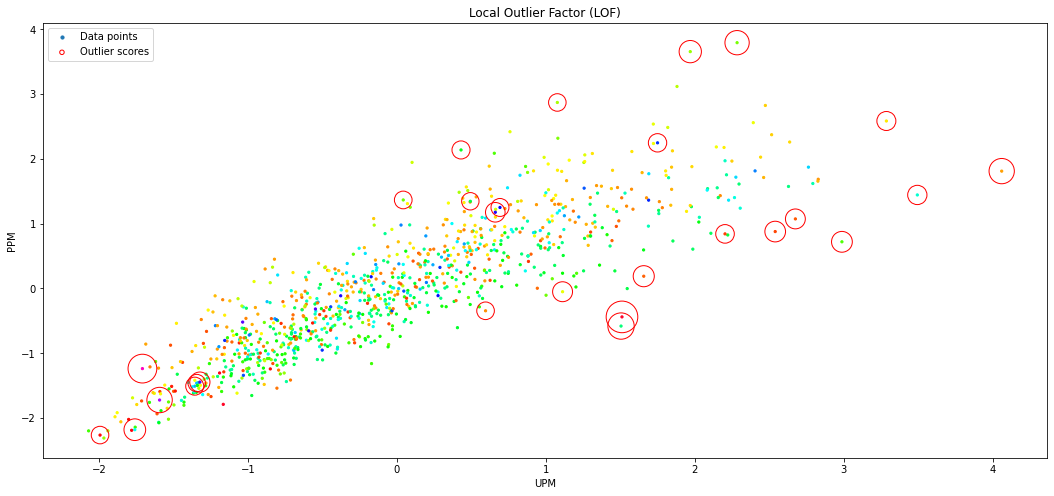

In [38]:
i, j = 1, 2

from sklearn.neighbors import LocalOutlierFactor

ground_truth = np.ones(len(scalled_X), dtype=int)

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(scalled_X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(scalled_X[:, j], scalled_X[:, i], c=y,cmap='gist_rainbow', s=5, label="Data points")

# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())


radius[radius<0.3] = 0

plt.scatter(
    scalled_X[:, j],
    scalled_X[:, i],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.xlabel(X.columns[j])
plt.ylabel(X.columns[i])
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [39]:
output_df['OS'] = radius

In [40]:
output_df.to_csv('output.csv', index=False)

### Using DBSCAN Algorithm for Anomaly Detection
##### Density-based spatial clustering of applications with noise is a density-based clustering machine learning algorithm to cluster normal data and detect outliers in an unsupervised manner. It clusters data points based on continuous regions of high point density and determines the ideal number of clusters to be formed. With such a density-based approach, outliers remain without any cluster and are, thus, easily spotted. In contrast to k-means, not all points are assigned to a cluster, and we are not required to declare the number of clusters (k). However, the two key parameters in DBSCAN are minPts (to set the minimum number of data points required to make a cluster) and eps (allowed distance between two points to put them in the same cluster).

In [46]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=.7, min_samples=4).fit(scalled_X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 11


In [47]:
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

Silhouette Coefficient: 0.456


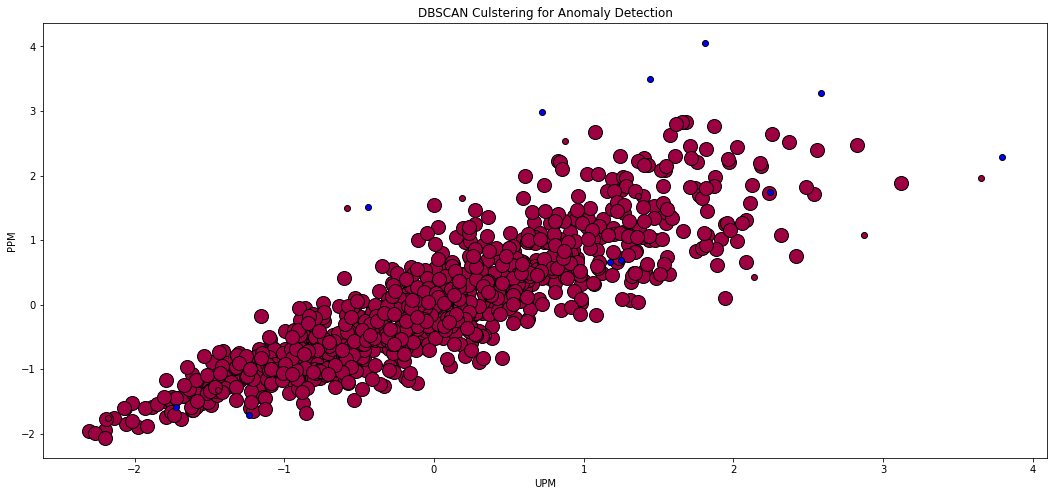

In [57]:

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 1, 1]

    class_member_mask = labels == k

    xy = scalled_X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, i],
        xy[:, j],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = scalled_X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, i],
        xy[:, j],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("DBSCAN Culstering for Anomaly Detection")
plt.xlabel(X.columns[j])
plt.ylabel(X.columns[i])
plt.show()

### References
##### How to do Anomaly Detection using Machine Learning in Python?
##### https://www.projectpro.io/article/anomaly-detection-using-machine-learning-in-python-with-example/555

##### Scikit Learn Novelty and Outlier Detection
##### https://scikit-learn.org/